In [1]:
##### base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# matplotlib
%matplotlib inline

# display
from IPython.display import display

# autoreload
%load_ext autoreload
%autoreload 2

# warnings
import warnings
warnings.filterwarnings('ignore')

# fix random seed
from numpy.random import seed as set_random_seed
set_random_seed(42)


# debug
from icecream import ic
debug = ic


In [4]:
from data_extraction.articles import get_articles
articles_processed = get_articles(processed=True)
articles_processed.sample().iloc[0]
for col in articles_processed.columns:
    articles_processed = articles_processed[articles_processed[col].str.len() > 0]
from spacy.lang.he.stop_words import STOP_WORDS
STOP_WORDS.update(',')
from feature_extraction.article import tokenize_article
articles = articles_processed.apply(tokenize_article, axis = 1, args = [[STOP_WORDS]])
raw_articles = get_articles()

data = pd.merge(
    articles,
    raw_articles,
    right_index = True,
    left_index = True,
    how = 'inner',
    suffixes= ('', '_raw')
)
#TODO: remove '?'

In [5]:
from utils.metric_utils import jaccard_score, bleu, rouge

def check_score(r, score = jaccard_score, *score_args, **score_kwargs):
    summary = r['summary_tokens']
    sub_title = r['sub_title']
    return score(sub_title[0], summary, *score_args, **score_kwargs)
# scores = data.apply(check_score, axis = 1, args = (bleu, 1))
# data['score'] = scores

In [6]:
test = data.sample(50)

In [7]:
from models.nlp.summarization.textrank import TextRankModel
from models.nlp.summarization.firstk import  FirstKModel
from scipy.special import expit


In [8]:
def compare_models(models: dict, metrics: dict, train, test, fit = False, plot = False):
    summaries_pred = {}
    scores_table = {}
    for model_name, model in models.items():
        if fit:
            model.fit(
                train['content'],
                train['content_raw'],
                y = train['sub_title'].apply(lambda l: l[0]),
            )
        summaries_pred[model_name] = model.predict(
            test['content'],
            test['content_raw']
        )
        scores_table[model_name] = {}
    for metric_name, metric_args in metrics.items():
        for model_name, model in models.items():
            data = test.copy(deep=True)
            data = pd.merge(
                data,
                summaries_pred[model_name],
                right_index = True,
                left_index = True,
                how = 'inner',
                suffixes= ('', '')
            )
            scores = data.apply(check_score, axis = 1, args = metric_args)
            score_mean = np.round(scores.mean(), 2)
            if plot:
                plt.hist(scores, label = f'{model_name}: {score_mean}', alpha = 1.5 * (1/len(models.keys())))
            scores_table[model_name][metric_name] = score_mean
        if plot:
            plt.title(f'Hisogram for {metric_name} score')
            plt.legend()
            plt.show()
    return pd.DataFrame(scores_table)

In [9]:
i = 0
N = 1
t = TextRankModel(STOP_WORDS, N=N)
s = t.predict(test['content'],test['content_raw'])
for ssum in s['summary']:
    print(ssum)
t = TextRankModel(STOP_WORDS,'word2vec',N=N)
s = t.predict(test['content'],test['content_raw'])
for ssum in s['summary']:
    print(ssum)
t = TextRankModel(STOP_WORDS,'word2vec',lambda x: pow(x,5),N=N)
s = t.predict(test['content'],test['content_raw'],N=N)
for ssum in s['summary']:
    print(ssum)

  0%|          | 0/50 [00:00<?, ?it/s]

    יצחק רבין - כתבות נוספות ב-ynet שבס: עמיר היה צריך לצאת מהכלא רק בארון מתים  פרס באזכרה לרבין: "עדיין נובטים גידולי פרא"  נתניהו השתווה לרבין: במקום ה-3 במשך הכהונה   מארגני האירוע נפגעו מברק שכינה עצמו לאורך השנים "ממשיך דרכו של רבין"
 כאשר יגיע יום פקודה, כאשר האלוף יפעיל את הצו, יגיעו אנשים לשא-נור מכל רחבי הארץ
 עמותת עובדי השוק, שפעלו כדי להביא את אנשי העבודה לשוק, מבטיחים לפרס כי אם אחד מהם יתקבל למרכז העבודה, הם יהפכו אותו לראש ממשלה
 יממה אחרי ששני חברי כנסת מיהדות התורה קיבלו מעטפות נאצה שהכילו אבקה חשודה, מכתבים בנוסח זהה נשלחו גם ללשכותיהם של שר הפנים, אלי ישי, ושל סגן שר הבריאות, יעקב ליצמן
 שאשא ביטון נשאלה על יכולותיהם הפוליטיות של סער ואלקין, שחוזרים כל הזמן על כך שיוכלו להרכיב ממשלה, והשיבה כי "גדעון סער הקים ממשלות במדינת ישראל, הוא שועל פוליטי ותיק
    "צריך אם כן לזכור ולהזכיר כי כל עוד החוק והחברה מפלים את האישה באשר היא אישה, הדמוקרטיה אינה דמוקרטיה אלא הסדר פונקציונלי בין מפלגות המחלקות ביניהן את השלטון
    בנוגע לבחירות לתפקיד היו"ר יוצגו למתפקדים שתי אפשרויו

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
test = test.sample(10)
len(test)

10

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

ic| intersection: {'יציין', 'רבין', 'את', 'מחר', 'מרכז'}
ic| len(union): 15
ic| intersection: {',',
                   'אלוף',
                   'אמש',
                   'חתם',
                   'יאיר',
                   'מרכז',
                   'נוה',
                   'על',
                   'פיקוד',
                   'צו',
                   'שומרון'}
ic| len(union): 31
ic| intersection: {',', 'על'}
ic| len(union): 31
ic| intersection: {'איומים', 'קללות', ','}
ic| len(union): 29
ic| intersection: {'כי', 'נתניהו', 'את', 'לא', ',', 'ציבור'}
ic| len(union): 46
ic| intersection: set()
ic| len(union): 18
ic| intersection: {'או',
                   'אינטרנטי',
                   'בית',
                   'טלפוני',
                   'יו',
                   'מחוזי',
                   'מפלגה',
                   'משאל',
                   'משפט',
                   'עבודה',
                   'קבע'}
ic| len(union): 33
ic| intersection: {'כי', 'ליכוד', 'גורמים'}
ic| len(union): 43

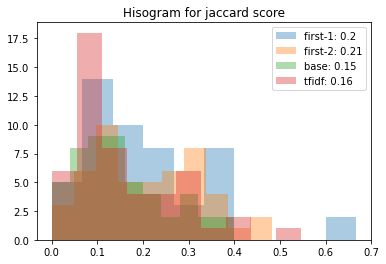

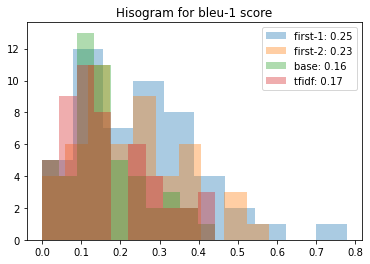

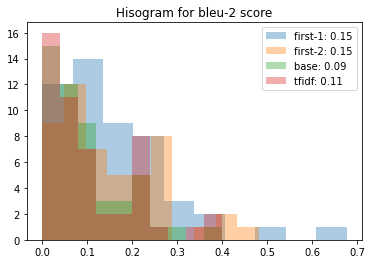

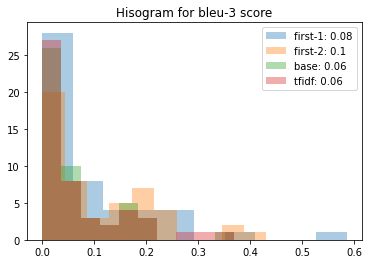

In [14]:
scores_table = compare_models(
    train = data,
    test = test,
    models = {
        'first-1': FirstKModel(STOP_WORDS, k=1),
        'first-2': FirstKModel(STOP_WORDS, k=2),
        'base-1': TextRankModel(STOP_WORDS, N=1),
        'tfidf-1': TextRankModel(STOP_WORDS,'tfidf', N=1),
        'base-2': TextRankModel(STOP_WORDS, N=2),
        'tfidf-2': TextRankModel(STOP_WORDS,'tfidf', N=2),
    },
    metrics = {
        'jaccard': (jaccard_score,),
        'bleu-1': (bleu, 1),
        'bleu-2': (bleu, 2),
        'bleu-3': (bleu, 3),
        # 'rouge-1': (rouge, 1),
        # 'rouge-2': (rouge, 2),
        # 'rouge-3': (rouge, 3),
        # 'rouge-L': (rouge, 'L'),
    },
    fit = False,
    plot = True
)

In [15]:
scores_table

,first-1,first-2,base,tfidf
jaccard,0.20,0.21,0.15,0.16
bleu-1,0.25,0.23,0.16,0.17
bleu-2,0.15,0.15,0.09,0.11
bleu-3,0.08,0.10,0.06,0.06
